In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import requests
import datetime 
from datetime import date
from pprint import pprint

In [221]:
url = 'https://api.worldbank.org/v2/country?format=json'
results = requests.get(url).json()
pages = results[0]['pages']

In [264]:
countries = results[1]
regions_df = pd.DataFrame(columns=['Country_Region', 'Region'])

for page in range(pages):
    for country in range(len(countries)):
        regions_df = regions_df.append({
            'Country_Region': countries[country]['name'],
            'Region': countries[country]['region']['value'],
        }, ignore_index=True)

regions_df = regions_df.set_index('Country_Region')
regions_df.head()

,Region
Country_Region,
Aruba,Latin America & Caribbean
Afghanistan,South Asia
Africa,Aggregates
Angola,Sub-Saharan Africa
Albania,Europe & Central Asia


## Cleaning the Data

In [223]:
# Both clinically diagnosed and lab-confirmed cases
# Source: https://www.kaggle.com/c/covid19-global-forecasting-week-2

train_data = os.path.join('resources','train.csv')
train_df = pd.read_csv(train_data)
train_df = train_df[['Province_State','Country_Region','Date','ConfirmedCases','Fatalities']]
train_df['Province_State'] = train_df['Province_State'].fillna('')
# train_df.head()

## Confirmed Cases Data

In [255]:
confirmed_df = train_df.pivot_table(index=['Country_Region','Province_State'], columns='Date', values='ConfirmedCases')
confirmed_df = confirmed_df.groupby('Country_Region').sum()
confirmed_df.head()

Date,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25
Country_Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,22.0,22.0,22.0,24.0,24.0,40.0,40.0,74.0,84.0
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.0,55.0,59.0,64.0,70.0,76.0,89.0,104.0,123.0,146.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,54.0,60.0,74.0,87.0,90.0,139.0,201.0,230.0,264.0,302.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,39.0,39.0,53.0,75.0,88.0,113.0,133.0,164.0,188.0
Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,3.0,3.0


In [266]:
confirmed_df2 = pd.merge(regions_df, confirmed_df, on=['Country_Region'], how='right')
confirmed_df2 = confirmed_df2.drop_duplicates().sort_values(by='Country_Region')
confirmed_regions = confirmed_df2.groupby('Region').sum()
confirmed_regions

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25
Region,,,,,,,,,,,,,,,,,,,,,
East Asia & Pacific,548.0,643.0,920.0,1406.0,2079.0,2882.0,5514.0,6093.0,8150.0,9811.0,...,81410.0,81510.0,81670.0,81837.0,82041.0,82376.0,82984.0,83180.0,83635.0,84025.0
Europe & Central Asia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4522.0,5604.0,6551.0,8367.0,10549.0,12913.0,15307.0,17974.0,20517.0,22618.0
Latin America & Caribbean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,423.0,604.0,704.0,974.0,1376.0,1742.0,2483.0,3019.0,3607.0,4138.0
Middle East & North Africa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,...,312.0,326.0,369.0,418.0,425.0,458.0,487.0,575.0,640.0,752.0
North America,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,4.0,...,413.0,470.0,648.0,791.0,933.0,1267.0,1456.0,2075.0,2777.0,3238.0
South Asia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.0,33.0,37.0,40.0,46.0,51.0,69.0,75.0,115.0,125.0
Sub-Saharan Africa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,17.0,23.0,36.0,46.0,71.0,82.0,110.0,126.0,158.0


### Top Ten Countries with Highest Number of Confirmed Cases

In [267]:
n = 10
last_day = confirmed_df.columns[-1]
top_confirmed_df = confirmed_df.nlargest(n, last_day)
top_confirmed_df

Date,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25
Country_Region,,,,,,,,,,,,,,,,,,,,,
China,548.0,643.0,920.0,1406.0,2075.0,2877.0,5509.0,6087.0,8141.0,9802.0,...,81033.0,81058.0,81102.0,81156.0,81250.0,81305.0,81435.0,81498.0,81591.0,81661.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,27980.0,31506.0,35713.0,41035.0,47021.0,53578.0,59138.0,63927.0,69176.0,74386.0
US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4565.0,6353.0,7715.0,13608.0,19025.0,25414.0,33663.0,43586.0,53659.0,65701.0
Spain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9942.0,11748.0,13910.0,17963.0,20410.0,25374.0,28768.0,35136.0,39885.0,49515.0
Germany,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,...,7272.0,9257.0,12327.0,15320.0,19848.0,22213.0,24873.0,29056.0,32986.0,37323.0
Iran,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14991.0,16169.0,17361.0,18407.0,19644.0,20610.0,21638.0,23049.0,24811.0,27017.0
France,0.0,0.0,2.0,3.0,3.0,3.0,4.0,5.0,5.0,5.0,...,6683.0,7715.0,9124.0,10970.0,12758.0,14463.0,16243.0,20123.0,22622.0,25600.0
Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2200.0,2700.0,3028.0,4075.0,5294.0,6575.0,7474.0,8795.0,9877.0,10897.0
United Kingdom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1551.0,1960.0,2642.0,2716.0,4014.0,5067.0,5745.0,6726.0,8164.0,9640.0


## Fatalities Data

In [268]:
fatalities_df = train_df.pivot_table(index=['Country_Region','Province_State'], columns='Date', values='Fatalities')
fatalities_df = fatalities_df.groupby('Country_Region').sum()
fatalities_df.head()

Date,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25
Country_Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,4.0,5.0,5.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,4.0,7.0,9.0,11.0,15.0,17.0,17.0,19.0,21.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Top Ten Countries with Highest Number of Fatalities

In [269]:
top_fatalities_df = fatalities_df.nlargest(n, last_day)
top_fatalities_df

Date,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25
Country_Region,,,,,,,,,,,,,,,,,,,,,
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2158.0,2503.0,2978.0,3405.0,4032.0,4825.0,5476.0,6077.0,6820.0,7503.0
Spain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,342.0,533.0,623.0,830.0,1043.0,1375.0,1772.0,2311.0,2808.0,3647.0
China,17.0,18.0,26.0,42.0,56.0,82.0,131.0,133.0,171.0,213.0,...,3217.0,3230.0,3241.0,3249.0,3253.0,3259.0,3274.0,3274.0,3281.0,3285.0
Iran,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,853.0,988.0,1135.0,1284.0,1433.0,1556.0,1685.0,1812.0,1934.0,2077.0
France,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,149.0,149.0,149.0,244.0,451.0,563.0,676.0,862.0,1102.0,1333.0
US,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85.0,108.0,118.0,200.0,244.0,307.0,426.0,551.0,705.0,941.0
United Kingdom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.0,56.0,72.0,138.0,178.0,234.0,282.0,336.0,423.0,466.0
Netherlands,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.0,43.0,58.0,77.0,107.0,137.0,180.0,214.0,277.0,357.0
Germany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,24.0,28.0,44.0,67.0,84.0,94.0,123.0,157.0,206.0


## Charting Actual COVID-19 Spread

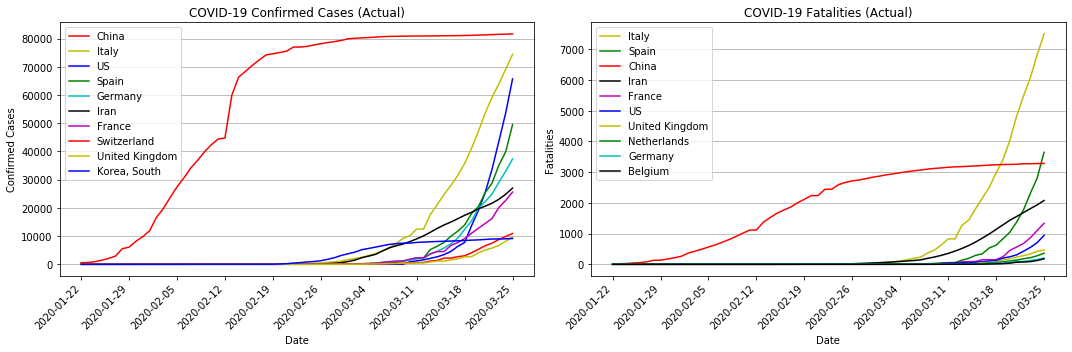

In [270]:
# x-axis
dates = confirmed_df.columns.tolist()   # dates in string format
days = range(len(dates))                # number of days

# y-axis: Confirmed Cases
c_countries = top_confirmed_df.index      # list of countries
top_confirmed = top_confirmed_df.values.tolist()  # total confirmed cases

# y-axis: Fatalities
f_countries = top_fatalities_df.index      # list of countries
top_fatalities = top_fatalities_df.values.tolist()  # total fatalities

# Subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

# x-axis labels
xticks = [day*7 for day in days]   # per week
xlabels = dates[0::7]

ax1.set(xlabel="Date", ylabel="Confirmed Cases")
ax1.set_xticks(xticks) 
ax1.set_xticklabels(xlabels, rotation=45, ha='right')
ax2.set(xlabel="Date", ylabel="Fatalities")
ax2.set_xticks(xticks) 
ax2.set_xticklabels(xlabels, rotation=45, ha='right')

# Chart titles
ax1.set_title("COVID-19 Confirmed Cases (Actual)")
ax2.set_title("COVID-19 Fatalities (Actual)")

line_color = {'China': 'r',
          'Italy': 'y',
          'US': 'b',
          'Spain': 'g',
          'Germany': 'c',
          'Iran': 'k',
          'France': 'm',
          'Switzerland': 'r',
          'United Kingdom': 'y',
          'Korea, South': 'b',
          'Netherlands': 'g',
          'Belgium': 'k'
         }

# Confirmed Cases Line Chart
c_labels = ()
c_counter = 0

for country in c_countries:
    ax1.plot(days, top_confirmed[c_counter], 
             label = c_countries, 
             color = line_color[country], linestyle = '-')

    c_labels += (country,)
    c_counter += 1

# Fatalities Cases Line Chart
f_labels = ()
f_counter = 0
for country in f_countries:
    ax2.plot(days, top_fatalities[f_counter], 
             label = f_countries, 
             color = line_color[country], linestyle = '-')

    f_labels += (country,)
    f_counter += 1
    
# Legends and chart style    
ax1.legend(c_labels, loc='best')
ax2.legend(f_labels, loc='best')
ax1.grid(axis='y'), ax2.grid(axis='y')

# Save Image
plt.savefig("images/actual.png")
plt.tight_layout()
plt.show()

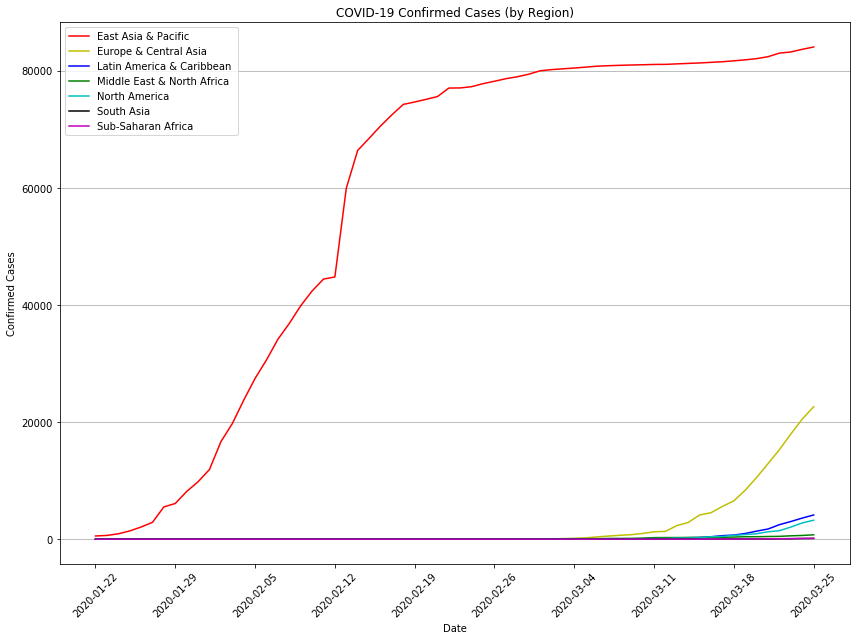

In [290]:
# Plot the data

# x-axis
dates = confirmed_regions.columns.tolist()   # dates in string format
days = range(len(dates))                # number of days

# y-axis
regions = confirmed_regions.index      # list of regions
top_confirmed = confirmed_regions.values.tolist()  # total confirmed cases

fig, ax = plt.subplots(figsize = (12,9))
plt.title("COVID-19 Confirmed Cases (by Region)")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")

xticks = [day*7 for day in days]
xlabels = dates[0::7]
plt.xticks(xticks, xlabels, rotation=45)

mcolor = ['r','y','b','g','c','k','m']
counter = 0
region_labels = ()

for region in regions:
    ax.plot(days, top_confirmed[counter], label = regions, color = mcolor[counter], linestyle = '-')

    region_labels += (region,)
    counter += 1
            
    if counter == len(regions):
        break
            
plt.legend(region_labels, loc='best')            
plt.grid(axis='y')
plt.savefig("images/actual_regions.png")
plt.tight_layout()
plt.show()

## Charting Actual COVID-19 Spread Since First Day

In [271]:
us = list(top_confirmed_df.loc[top_confirmed_df.index == "US"].values[0])
us_index = next((i for i, j in enumerate(us) if j.any()), None)     
first_in_us = top_confirmed_df.columns[us_index]
first_in_us

'2020-03-10'

In [272]:
first_confirmed_df = pd.DataFrame(columns=days)

for country in c_countries:
    # Grab the country's row
    y = list(top_confirmed_df.loc[top_confirmed_df.index == country].values[0])
    # Grab the column index of first non-zero value
    reset_index = next((i for i, j in enumerate(y) if j.any()), None)     
    # Calculate date
    first_day = top_confirmed_df.columns[reset_index]
    # Reset first day
    y = y[reset_index:] + y[:reset_index]
    # New rearranged dataframe
    first_confirmed_df = first_confirmed_df.append([y])

# Same countries indexed
first_confirmed_df.index = top_confirmed_df.index
first_confirmed_df = first_confirmed_df.replace(0,np.NaN)
first_confirmed_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Country_Region,,,,,,,,,,,,,,,,,,,,,
China,548.0,643.0,920.0,1406.0,2075.0,2877.0,5509.0,6087.0,8141.0,9802.0,...,81033.0,81058.0,81102.0,81156.0,81250.0,81305.0,81435.0,81498.0,81591.0,81661.0
Italy,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,...,74386.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US,892.0,1214.0,1596.0,2112.0,2658.0,3431.0,4565.0,6353.0,7715.0,13608.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spain,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Germany,1.0,4.0,4.0,4.0,5.0,8.0,10.0,12.0,12.0,12.0,...,22213.0,24873.0,29056.0,32986.0,37323.0,NaN,NaN,NaN,NaN,NaN
Iran,2.0,5.0,18.0,28.0,43.0,61.0,95.0,139.0,245.0,388.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
France,2.0,3.0,3.0,3.0,4.0,5.0,5.0,5.0,6.0,6.0,...,9124.0,10970.0,12758.0,14463.0,16243.0,20123.0,22622.0,25600.0,NaN,NaN
Switzerland,1.0,1.0,8.0,8.0,18.0,27.0,42.0,56.0,90.0,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
United Kingdom,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,...,9640.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [293]:
first_confirmed_r_df = pd.DataFrame(columns=days)

for region in regions:
    # Grab the country's row
    y = list(confirmed_regions.loc[confirmed_regions.index == region].values[0])
    # Grab the column index of first non-zero value
    reset_index = next((i for i, j in enumerate(y) if j.any()), None)     
    # Calculate date
    first_day = confirmed_regions.columns[reset_index]
    # Reset first day
    y = y[reset_index:] + y[:reset_index]
    # New rearranged dataframe
    first_confirmed_r_df = first_confirmed_r_df.append([y])

# Same countries indexed
first_confirmed_r_df.index = confirmed_regions.index
first_confirmed_r_df = first_confirmed_r_df.replace(0,np.NaN)
first_confirmed_r_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Region,,,,,,,,,,,,,,,,,,,,,
East Asia & Pacific,548.0,643.0,920.0,1406.0,2079.0,2882.0,5514.0,6093.0,8150.0,9811.0,...,81410.0,81510.0,81670.0,81837.0,82041.0,82376.0,82984.0,83180.0,83635.0,84025.0
Europe & Central Asia,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latin America & Caribbean,1.0,1.0,1.0,2.0,2.0,2.0,4.0,6.0,9.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Middle East & North Africa,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,...,575.0,640.0,752.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
North America,1.0,1.0,2.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,...,933.0,1267.0,1456.0,2075.0,2777.0,3238.0,NaN,NaN,NaN,NaN
South Asia,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sub-Saharan Africa,1.0,2.0,2.0,2.0,2.0,4.0,17.0,17.0,23.0,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [273]:
first_fatalities_df = pd.DataFrame(columns=days)

for country in f_countries:
    # Grab the country's row
    y = list(top_fatalities_df.loc[top_fatalities_df.index == country].values[0])
    # Grab the column index of first non-zero value
    reset_index = next((i for i, j in enumerate(y) if j.any()), None)     
    # Calculate date
    first_day = top_fatalities_df.columns[reset_index]
    # Reset first day
    y = y[reset_index:] + y[:reset_index]
    # New rearranged dataframe
    first_fatalities_df = first_fatalities_df.append([y])

# Same countries indexed    
first_fatalities_df.index = top_fatalities_df.index
first_fatalities_df = first_fatalities_df.replace(0,np.NaN)
first_fatalities_df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
Country_Region,,,,,,,,,,,,,,,,,,,,,
Italy,1.0,2.0,3.0,7.0,10.0,12.0,17.0,21.0,29.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spain,1.0,2.0,3.0,5.0,10.0,17.0,28.0,35.0,54.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
China,17.0,18.0,26.0,42.0,56.0,82.0,131.0,133.0,171.0,213.0,...,3217.0,3230.0,3241.0,3249.0,3253.0,3259.0,3274.0,3274.0,3281.0,3285.0
Iran,2.0,2.0,4.0,5.0,8.0,12.0,16.0,19.0,26.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
France,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US,28.0,36.0,40.0,47.0,54.0,63.0,85.0,108.0,118.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
United Kingdom,1.0,2.0,2.0,3.0,4.0,6.0,8.0,8.0,8.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Netherlands,1.0,1.0,3.0,3.0,4.0,5.0,5.0,10.0,12.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Germany,2.0,2.0,3.0,3.0,7.0,9.0,11.0,17.0,24.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


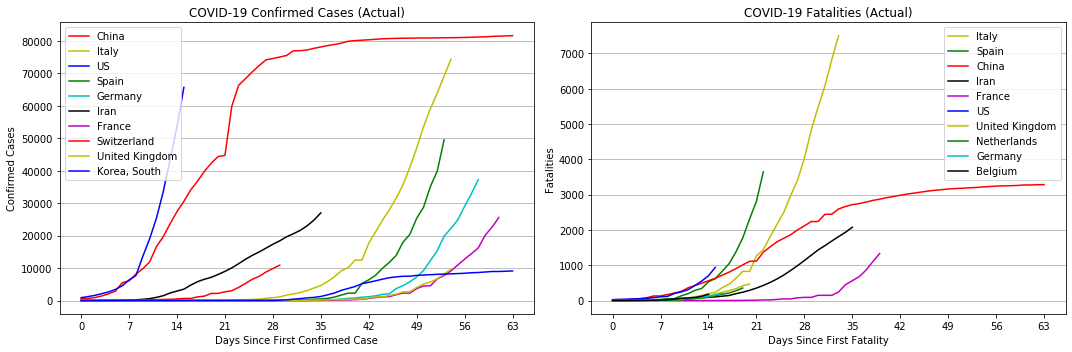

In [274]:
# Subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

# x-axis labels
ax1.set(xlabel="Days Since First Confirmed Case", ylabel="Confirmed Cases")
ax1.set_xticks(xticks) 
ax2.set(xlabel="Days Since First Fatality", ylabel="Fatalities")
ax2.set_xticks(xticks) 

# Chart titles
ax1.set_title("COVID-19 Confirmed Cases (Actual)")
ax2.set_title("COVID-19 Fatalities (Actual)")

# Confirmed Cases Line Chart
c_labels = ()
c_counter = 0

first_confirmed = pd.DataFrame(columns=days)

for country in c_countries:
    y = first_confirmed_df.loc[first_confirmed_df.index == country].values[0]
   
    ax1.plot(days, y, 
             label = c_countries, 
             color = line_color[country], linestyle = '-')

    c_labels += (country,)
    c_counter += 1
        

# Fatalities Line Chart
f_labels = ()
f_counter = 0

for country in f_countries:
    y = first_fatalities_df.loc[first_fatalities_df.index == country].values[0]
    
    ax2.plot(days, y, 
             label = f_countries, 
             color = line_color[country], linestyle = '-')

    f_labels += (country,)
    f_counter += 1    
    
# Legends and chart style    
ax1.legend(c_labels, loc='best')
ax2.legend(f_labels, loc='best')
ax1.grid(axis='y'), ax2.grid(axis='y')

# Save Image
plt.savefig("images/actual_days.png")
plt.tight_layout()
plt.show()

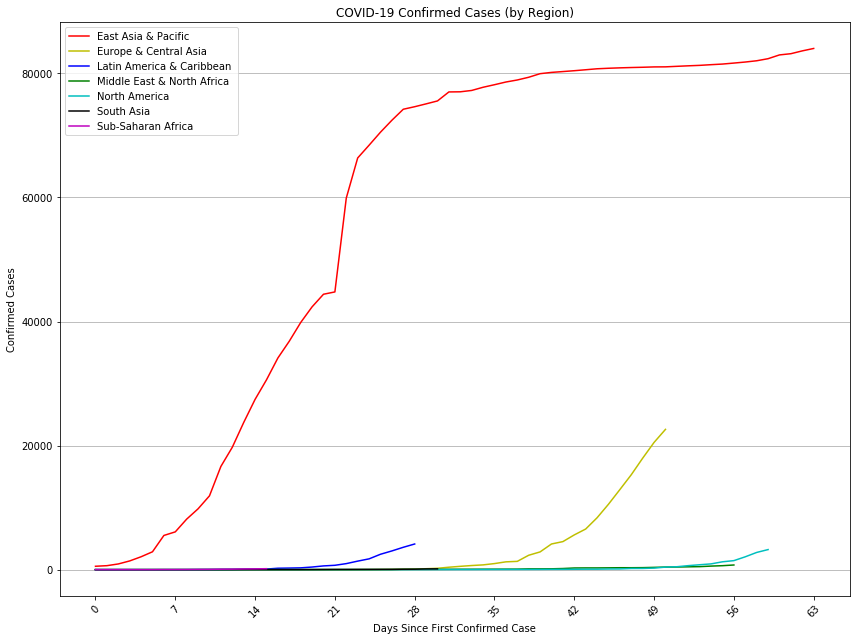

In [294]:
# Plot the data

# x-axis
dates = first_confirmed_r_df.columns.tolist()   # dates in string format
days = range(len(dates))                # number of days

# y-axis
regions = first_confirmed_r_df.index      # list of regions
top_confirmed = first_confirmed_r_df.values.tolist()  # total confirmed cases

fig, ax = plt.subplots(figsize = (12,9))
plt.title("COVID-19 Confirmed Cases (by Region)")
plt.xlabel("Days Since First Confirmed Case")
plt.ylabel("Confirmed Cases")

xticks = [day*7 for day in days]
xlabels = dates[0::7]
plt.xticks(xticks, xlabels, rotation=45)

mcolor = ['r','y','b','g','c','k','m']
counter = 0
region_labels = ()

for region in regions:
    ax.plot(days, top_confirmed[counter], label = regions, color = mcolor[counter], linestyle = '-')

    region_labels += (region,)
    counter += 1
            
    if counter == len(regions):
        break
            
plt.legend(region_labels, loc='best')            
plt.grid(axis='y')
plt.savefig("images/actual_regions_days.png")
plt.tight_layout()
plt.show()

## Recovered Cases

In [275]:
# Source: https://github.com/CSSEGISandData/COVID-19/
recovered_df = pd.read_csv('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

# Sum values by Country/Region
recovered_df = recovered_df.groupby('Country/Region').sum()
recovered_df = recovered_df.drop(['Lat','Long'], axis=1)
recovered_df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,2,2,2
Albania,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,10,17,17,31
Algeria,0,0,0,0,0,0,0,0,0,0,...,12,32,32,32,65,65,24,65,29,29
Andorra,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Angola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Polynomial Regression Model

In [276]:
# Installations you may need to run this notebook
# !pip install keras
# !pip install tensorflow
# !pip install sklearn --upgrade
# !pip install joblib

# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import numpy.polynomial.polynomial as poly
from scipy.optimize import curve_fit

## Charting Predicted COVID-19 Spread

In [277]:
from datetime import datetime as dt

# Prediction Dates
test_data = os.path.join('resources','test.csv')
test_df = pd.read_csv(test_data)

# Start Date
start = test_df['Date'].min()
start = dt.strptime(start, '%Y-%m-%d')

# End Date
end = test_df['Date'].max()
end = dt.strptime(end, '%Y-%m-%d')

# Date Range
n_days = (end-start).days
n_days

42

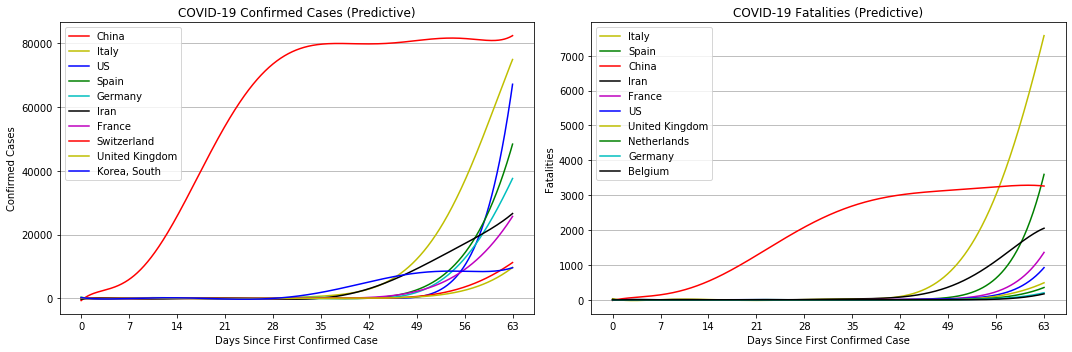

In [278]:
i_days = n_days - 1   # adjust for index
degree = 7

# Subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

# x-axis labels
ax1.set(xlabel="Days Since First Confirmed Case", ylabel="Confirmed Cases")
ax1.set_xticks(xticks) 
ax2.set(xlabel="Days Since First Confirmed Case", ylabel="Fatalities")
ax2.set_xticks(xticks) 

# Chart titles
ax1.set_title("COVID-19 Confirmed Cases (Predictive)")
ax2.set_title("COVID-19 Fatalities (Predictive)")

# Confirmed Cases Line Chart
c_labels = ()
c_counter = 0

first_confirmed = pd.DataFrame(columns=days)

for country in c_countries:
    
    y = top_confirmed_df.loc[top_confirmed_df.index == country].values[0]
   
    c_polynomial = np.poly1d(np.polyfit(days, y, degree))
    c_polyline = np.linspace(0, days[-1], 1000)
#     c_polyline = np.linspace(days[-1], days[-1]+n_days, 1000)
    ax1.plot(c_polyline, c_polynomial(c_polyline), 
             c = line_color[country], 
             label = c_countries)

#     model_score = r2_score(y, c_polynomial(days))
#     prediction = round(c_polynomial(n_days), -3)  # rounded to 1000's

    c_labels += (country,)
    c_counter += 1
        

# Fatalities Line Chart
f_labels = ()
f_counter = 0

for country in f_countries:
    y = top_fatalities_df.loc[top_fatalities_df.index == country].values[0]
    
    f_polynomial = np.poly1d(np.polyfit(days, y, degree))
    f_polyline = np.linspace(0, days[-1], 1000)
#     f_polyline = np.linspace(days[-1], days[-1]+n_days, 1000)
    ax2.plot(f_polyline, f_polynomial(f_polyline), 
             c = line_color[country], 
             label = f_countries)

#     model_score = r2_score(y, f_polynomial(days))
#     prediction = round(f_polynomial(n_days), -3)  # rounded to 1000's
    
    f_labels += (country,)
    f_counter += 1    
    
# Legends and chart style    
ax1.legend(c_labels, loc='best')
ax2.legend(f_labels, loc='best')
ax1.grid(axis='y'), ax2.grid(axis='y')

# Save Image
plt.savefig("images/predicted.png")
plt.tight_layout()
plt.show()

In [279]:
# # Separate Training Data (80%) to create model v. Test Data (20%) to test
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# # Train the model using the training data
# model.fit(X_train, y_train)

# # And score the model using the unseen testing data
# print(f"Training Data Score: {model.score(X_train, y_train)}")
# print(f"Testing Data Score: {model.score(X_test, y_test)}")

## SIR Model

In [280]:
# Parameters
code = 'SP.POP.65UP.TO'
code = 'SP.POP.65UP.TO'
code = 'SP.POP.65UP.TO'
code = 'SP.POP.65UP.TO'
country = 'WLD'

# API call
url="https://api.worldbank.org/v2/country/WLD/indicator/SP.POP.TOTL?format=json"
url = f"https://api.worldbank.org/v2/country/{country}/indicator/{code}?format=json"
response = requests.get(url).json()

pop65up = response[1][1]['value']
pop65up

673618927

In [281]:
code = 'SP.POP.TOTL'
country = 'WLD'

# API call
url = f"https://api.worldbank.org/v2/country/{country}/indicator/{code}?format=json"
response = requests.get(url).json()
population = response[1][1]['value']
population

7594270356

In [282]:
global_confirmed = confirmed_df.iloc[:,-1].sum()
global_recovered = recovered_df.iloc[:,-1].sum()
global_fatalities = fatalities_df.iloc[:,-1].sum()
print(f"Infected: {global_confirmed}, Removed: {global_recovered + global_fatalities}")

Infected: 467504.0, Removed: 152094.0


In [283]:
# Total population, N.
# N = 1000
N = population
# Initial number of infected and recovered individuals, I0 and R0.
# I0, R0 = 0, 1
I0, R0 = global_confirmed, global_recovered + global_fatalities
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
# beta, gamma = 0.2, 1./10 
beta, gamma = 0.1, 1./38
# A grid of time points (in days)
# t = np.linspace(0, 160, 160)
t = np.linspace(0, 365, 160)

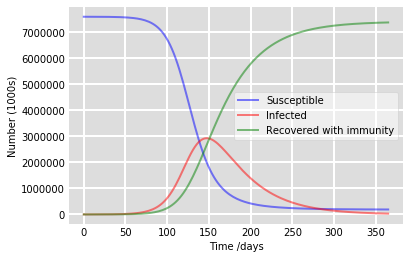

In [284]:
from scipy.integrate import odeint

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Population Density (per sqkm) (2018)

In [285]:
# Source: https://data.worldbank.org/indicator/en.pop.dnst
file = os.path.join('resources','population_density.csv')
pop_density = pd.read_csv(file, header=4, usecols=['Country Name','2018'], index_col='Country Name')
pop_density = pop_density.rename(columns={'2018':'Population Density'})
print(len(pop_density))
pop_density.head()

264


,Population Density
Country Name,
Aruba,588.027778
Afghanistan,56.937760
Angola,24.713052
Albania,104.612263
Andorra,163.842553


In [286]:
pop_density_df = pop_density.join(confirmed_df, how='inner')
print(len(pop_density_df))
pop_density_df.head()

151


,Population Density,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25
Afghanistan,56.937760,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.0,22.0,22.0,22.0,24.0,24.0,40.0,40.0,74.0,84.0
Angola,24.713052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,2.0,3.0,3.0,3.0
Albania,104.612263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.0,55.0,59.0,64.0,70.0,76.0,89.0,104.0,123.0,146.0
Andorra,163.842553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,39.0,39.0,53.0,75.0,88.0,113.0,133.0,164.0,188.0
United Arab Emirates,135.609110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,...,98.0,98.0,113.0,140.0,140.0,153.0,153.0,198.0,248.0,333.0


## Population Demographics

## Pre-existing Health Conditions/Burden of Disease